# Forecasting the onset of communal conflict in Ethiopia:
### Duration: one year ahead
### Frequency: Monthly 
### Admin level: Admin2
### Methodology: LSTM Autoencoder for extreme rare event classification


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)
from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["No Conflict","Conflict"]

/Users/yaredhurisa/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/yaredhurisa/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/yaredhurisa/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/yaredhurisa/anaconda3/lib/python3.7/site-packages/tensorf

In [2]:
df = pd.read_csv('/Users/yaredhurisa/Google Drive/Probability of conflict/indicators/eth_cc_final_dataset_monthly.csv')
list(df.columns)

['Unnamed: 0',
 'group',
 'date',
 'cc_onset',
 'fatalities',
 'cc_onset_1',
 'fatalities_1',
 'actor_state_1',
 'actor_rebel_groups_1',
 'actor_political_militias_1',
 'actor_identity_militias_1',
 'actor_civilians_1',
 'actor_others_1',
 'inflation_all_1',
 'rainfall_1',
 'temperature_1',
 'pop_1',
 'maize_kg_birr_1',
 'teff_kg_birr_1',
 'wheat_kg_birr_1',
 'ndvi_1',
 'fs_crisis_1',
 'df_emergency_1',
 'fs_famine_1',
 'fs_minimal_1',
 'fs_stressed_1',
 'cc_onset_2',
 'fatalities_2',
 'actor_state_2',
 'actor_rebel_groups_2',
 'actor_political_militias_2',
 'actor_identity_militias_2',
 'actor_civilians_2',
 'actor_others_2',
 'inflation_all_2',
 'rainfall_2',
 'temperature_2',
 'pop_2',
 'maize_kg_birr_2',
 'teff_kg_birr_2',
 'wheat_kg_birr_2',
 'ndvi_2',
 'fs_crisis_2',
 'df_emergency_2',
 'fs_famine_2',
 'fs_minimal_2',
 'fs_stressed_2',
 'cc_onset_3',
 'fatalities_3',
 'actor_state_3',
 'actor_rebel_groups_3',
 'actor_political_militias_3',
 'actor_identity_militias_3',
 'actor_ci

In [23]:
df.head()

,Unnamed: 0,group,date,cc_onset,fatalities,cc_onset_1,fatalities_1,actor_state_1,actor_rebel_groups_1,actor_political_militias_1,...,pop_12,maize_kg_birr_12,teff_kg_birr_12,wheat_kg_birr_12,ndvi_12,fs_crisis_12,df_emergency_12,fs_famine_12,fs_minimal_12,fs_stressed_12
0,1,Addis Ababa_Addis Ababa,1998-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.055693e+06,6.366733,10.491953,10.126039,143.936125,0.0,0.0,0.0,0.0,0.0
1,2,Addis Ababa_Addis Ababa,1999-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.893393e+06,6.294734,10.519060,10.158023,145.263097,0.0,0.0,0.0,0.0,0.0
2,3,Addis Ababa_Addis Ababa,2000-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.173030e+06,6.416730,10.470207,10.114585,143.656003,0.0,0.0,0.0,0.0,0.0
3,4,Addis Ababa_Addis Ababa,2001-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.460510e+06,6.154499,10.143197,9.958946,144.056314,0.0,0.0,0.0,0.0,0.0
4,5,Addis Ababa_Addis Ababa,2002-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.517836e+06,6.172404,10.275892,10.010577,143.325276,0.0,0.0,0.0,0.0,0.0


In [3]:
#Training, and test 
start_date = "2009-12-01"
end_date = "2018-01-01"
mask = (df['date'] > start_date) & (df['date'] < end_date)
train1 = df.loc[mask]


start_date = "2017-12-01"
end_date = "2019-01-01"
mask = (df['date'] > start_date) & (df['date'] < end_date)
test1 = df.loc[mask]

train = train1.drop(['Unnamed: 0', 'date', 'group','fatalities'], axis=1)
test = test1.drop(['Unnamed: 0','date', 'group','fatalities'], axis=1)



In [4]:
test.shape

(888, 253)

In [5]:
input_X = train.loc[:, train.columns != 'cc_onset'].values  # converts the df to a numpy array
input_y = train['cc_onset'].values

n_features = input_X.shape[1]  # number of features

def temporalize(X_train, y_train, lookback):
    '''
    Inputs
    X         A 2D numpy array ordered by time of shape: 
              (n_observations x n_features)
    y         A 1D numpy array with indexes aligned with 
              X, i.e. y[i] should correspond to X[i]. 
              Shape: n_observations.
    lookback  The window size to look back in the past 
              records. Shape: a scalar.

    Output
    output_X  A 3D numpy array of shape: 
              ((n_observations-lookback-1) x lookback x 
              n_features)
    output_y  A 1D array of shape: 
              (n_observations-lookback-1), aligned with X.
    '''
    output_X = []
    output_y = []
    for i in range(len(X_train) - lookback - 1):
        t = []
        for j in range(1, lookback + 1):
            # Gather the past records upto the lookback period
            t.append(X_train[[(i + j + 1)], :])
        output_X.append(t)
        output_y.append(y_train[i + lookback + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)


print('First instance of y = 1 in the original data')
display(train.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])
lookback = 2  # Equivalent to 10 min of past data.
# Temporalize the data
X_train, y_train = temporalize(X_train = input_X, y_train = input_y, lookback = lookback)
print('For the same instance of y = 1, we are keeping past 2 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X_train[np.where(np.array(y_train) == 1)[0][0]], axis=0 )))

First instance of y = 1 in the original data


,cc_onset,cc_onset_1,fatalities_1,actor_state_1,actor_rebel_groups_1,actor_political_militias_1,actor_identity_militias_1,actor_civilians_1,actor_others_1,inflation_all_1,...,pop_12,maize_kg_birr_12,teff_kg_birr_12,wheat_kg_birr_12,ndvi_12,fs_crisis_12,df_emergency_12,fs_famine_12,fs_minimal_12,fs_stressed_12
41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.3,...,3668349.0,7.027778,13.179777,13.414239,126.365419,0.0,0.0,0.0,0.0,0.0
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.9,...,3778249.0,7.997881,14.331003,16.155873,129.599734,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,3089964.0,5.769120,7.938155,5.981770,129.187857,0.0,0.0,0.0,0.0,0.0
59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.8,...,3177713.0,3.946806,7.804452,6.564507,136.042405,0.0,0.0,0.0,0.0,0.0
60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.9,...,3268409.0,4.333333,7.580150,7.411708,128.995505,0.0,0.0,0.0,0.0,0.0
61,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.3,...,3362496.0,5.297291,7.413709,6.208425,123.918947,0.0,0.0,0.0,0.0,0.0


For the same instance of y = 1, we are keeping past 2 samples in the 3D predictor array, X.


,0
0,0.000000e+00
1,0.000000e+00
2,0.000000e+00
3,0.000000e+00
4,0.000000e+00
5,0.000000e+00
6,0.000000e+00
7,0.000000e+00
8,3.590000e+01
9,7.493463e+00


In [6]:
#repeat for the test data
input_X = test.loc[:, test.columns != 'cc_onset'].values  # converts the df to a numpy array
input_y = test['cc_onset'].values

n_features = input_X.shape[1]  # number of features

def temporalize(X_test, y_test, lookback):
    '''
    Inputs
    X         A 2D numpy array ordered by time of shape: 
              (n_observations x n_features)
    y         A 1D numpy array with indexes aligned with 
              X, i.e. y[i] should correspond to X[i]. 
              Shape: n_observations.
    lookback  The window size to look back in the past 
              records. Shape: a scalar.

    Output
    output_X  A 3D numpy array of shape: 
              ((n_observations-lookback-1) x lookback x 
              n_features)
    output_y  A 1D array of shape: 
              (n_observations-lookback-1), aligned with X.
    '''
    output_X = []
    output_y = []
    for i in range(len(X_test) - lookback - 1):
        t = []
        for j in range(1, lookback + 1):
            # Gather the past records upto the lookback period
            t.append(X_test[[(i + j + 1)], :])
        output_X.append(t)
        output_y.append(y_test[i + lookback + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)


print('First instance of y = 1 in the original data')
display(test.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])
lookback = 2  # Equivalent to 10 min of past data.
# Temporalize the data
X_test, y_test = temporalize(X_test = input_X, y_test = input_y, lookback = lookback)
print('For the same instance of y = 1, we are keeping past 2 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X_test[np.where(np.array(y_test) == 1)[0][0]], axis=0 )))

First instance of y = 1 in the original data


,cc_onset,cc_onset_1,fatalities_1,actor_state_1,actor_rebel_groups_1,actor_political_militias_1,actor_identity_militias_1,actor_civilians_1,actor_others_1,inflation_all_1,...,pop_12,maize_kg_birr_12,teff_kg_birr_12,wheat_kg_birr_12,ndvi_12,fs_crisis_12,df_emergency_12,fs_famine_12,fs_minimal_12,fs_stressed_12
89,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,12.6,...,3891784.0,8.314511,14.711928,15.082420,129.551074,0.0,0.0,0.0,0.0,0.0
112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.1,...,3891784.0,8.324555,14.900207,15.649164,130.757934,0.0,0.0,0.0,0.0,0.0
135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.7,...,3891784.0,8.297307,14.834793,16.010007,129.985287,0.0,0.0,0.0,0.0,0.0
158,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,14.4,...,3891784.0,8.281500,20.884960,26.894569,127.797110,0.0,0.0,0.0,0.0,0.0
181,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14.8,...,3891784.0,8.498447,21.001567,27.697458,125.897517,0.0,0.0,0.0,0.0,0.0
204,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.1,...,3891784.0,9.034750,20.034844,25.388136,130.078042,0.0,0.0,0.0,0.0,0.0


For the same instance of y = 1, we are keeping past 2 samples in the 3D predictor array, X.


,0
0,0.000000e+00
1,1.000000e+00
2,0.000000e+00
3,0.000000e+00
4,0.000000e+00
5,0.000000e+00
6,0.000000e+00
7,0.000000e+00
8,1.480000e+01
9,2.877640e+02


In [7]:
# get the negatively labled data
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]
X_test_y0 = X_test[y_test==0]
X_test_y1 = X_test[y_test==1]

In [8]:
#reshape the X's into 3D dimensions: sample x lookbackx features
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)
X_test_y0 = X_test_y0.reshape(X_test_y0.shape[0], lookback, n_features)
X_test_y1 = X_test_y1.reshape(X_test_y1.shape[0], lookback, n_features)

In [9]:
#standardize the data (transfrm to Gaussian with mean 0 and std 1) for autoencoders

# flatten: recreate the orginal 2d array 
# scale: scale the 3D array created as input to the LSTM
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [10]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

In [11]:
X_train_y0_scaled = scale(X_train_y0, scaler)

In [12]:
# check if the scae is correct (mean and variance)
a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [-0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0. -0.  0. -0. -0. -0.
  0. -0. -0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.
 -0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0.
  0. -0.  0. -0. -0. -0.  0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.  0.
  0. -0.  0.  0.  0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0.  0.  0. -0.
  0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0.
  0.  0. -0. -0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0. -0.  0. -0. -0.
 -0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0. -0.  0.  0.
  0. -0.  0. -0.  0. -0.  0.  0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0.
 -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0. -0.  0.
  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0. -0.  0.  0. -0.  0.  0.  0.
  0. -0.  0.  0.  0.  0. -0. -0.  0.  0. -0.  0. -0. -0.  0.  0.  0. -0.
  0.  0.  0.  0. -0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. -0.  0.  

In [13]:
#scale the test
X_test_scaled = scale(X_test, scaler)
X_test_y0_scaled = scale(X_test_y0, scaler)


In [14]:
#LSTM Autoencoder training
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 59

epochs = 200
batch = 64
lr = 0.0001

In [15]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2, 32)             36480     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 2, 16)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 2, 16)             2112      
_________________________________________________________________
lstm_4 (LSTM)                (None, 2, 32)             6272      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2, 252)            8316      
Total params: 56,316
Trainable params: 56,316
Non-trainable params: 0
__________________________________________________

In [16]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_test_y0_scaled, X_test_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_test_y0_scaled, X_test_y0_scaled),
                                                verbose=2).history


Train on 806 samples, validate on 806 samples
Epoch 1/200
 - 1s - loss: 2.6000 - val_loss: 2.5996
Epoch 2/200
 - 0s - loss: 2.5993 - val_loss: 2.5989
Epoch 3/200
 - 0s - loss: 2.5985 - val_loss: 2.5981
Epoch 4/200
 - 0s - loss: 2.5978 - val_loss: 2.5974
Epoch 5/200
 - 0s - loss: 2.5970 - val_loss: 2.5965
Epoch 6/200
 - 0s - loss: 2.5961 - val_loss: 2.5956
Epoch 7/200
 - 0s - loss: 2.5951 - val_loss: 2.5944
Epoch 8/200
 - 0s - loss: 2.5938 - val_loss: 2.5930
Epoch 9/200
 - 0s - loss: 2.5922 - val_loss: 2.5910
Epoch 10/200
 - 0s - loss: 2.5898 - val_loss: 2.5879
Epoch 11/200
 - 0s - loss: 2.5857 - val_loss: 2.5821
Epoch 12/200
 - 0s - loss: 2.5782 - val_loss: 2.5719
Epoch 13/200
 - 0s - loss: 2.5652 - val_loss: 2.5552
Epoch 14/200
 - 0s - loss: 2.5454 - val_loss: 2.5323
Epoch 15/200
 - 0s - loss: 2.5202 - val_loss: 2.5056
Epoch 16/200
 - 0s - loss: 2.4948 - val_loss: 2.4802
Epoch 17/200
 - 0s - loss: 2.4705 - val_loss: 2.4568
Epoch 18/200
 - 0s - loss: 2.4473 - val_loss: 2.4348
Epoch 19

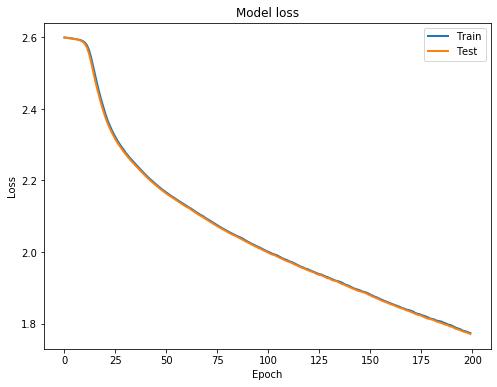

In [17]:
# plot the change in the loss over the epochs
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


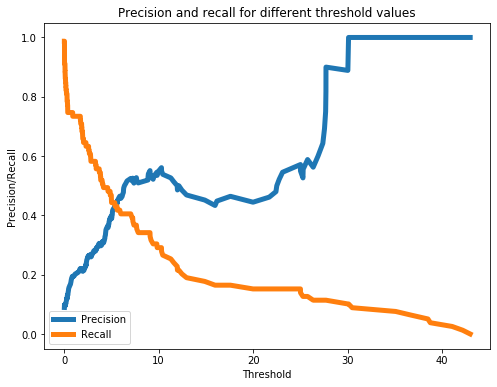

In [18]:
# Classification
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

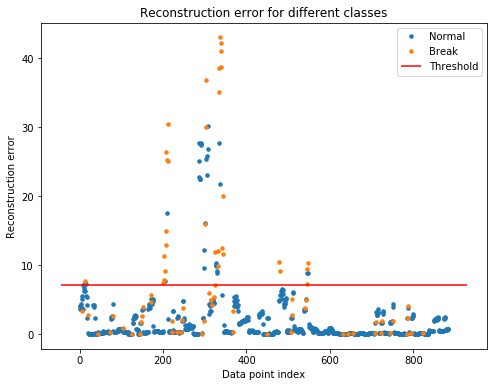

In [19]:
#perform the classification on the test data
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 7.1
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Conflict" if name == 1 else "No conflict")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


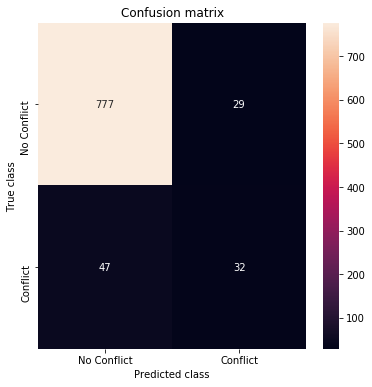

In [20]:
# Test accuracy using Confusion Matrix
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [21]:
#calculate precision, recall and f1-score
pred_y=pd.DataFrame(list(map(np.ravel, pred_y)))
print(pred_y.shape)
print(y_test.shape)
print(classification_report(y_test, pred_y))

(885, 1)
(885,)
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       806
         1.0       0.52      0.41      0.46        79

    accuracy                           0.91       885
   macro avg       0.73      0.68      0.71       885
weighted avg       0.91      0.91      0.91       885



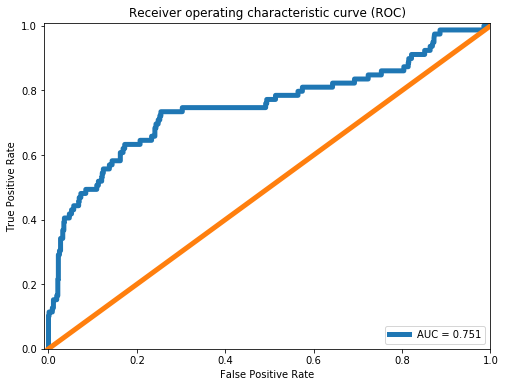

In [22]:
# ROC Curve and AUC
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()